In [1]:
#!/usr/bin/env python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Bernoulli, Normal
from edward.util import Progbar
from keras.layers import Dense
from scipy.misc import imsave
from tensorflow.examples.tutorials.mnist import input_data

DATA_DIR = "data/mnist"
IMG_DIR = "img"

if not os.path.exists(DATA_DIR):
  os.makedirs(DATA_DIR)
if not os.path.exists(IMG_DIR):
  os.makedirs(IMG_DIR)

Using TensorFlow backend.


In [2]:
ed.set_seed(42)

In [3]:
M = 5000 # batch size during training
d = 2 #latent dimension
alpha = 0.01
n_samples = 5   # number of samples used to estimate the ELBO

# DATA. MNIST batches are fed at training time.
mnist = input_data.read_data_sets(DATA_DIR)

# MODEL
# Define a subgraph of the full model, corresponding to a minibatch of
# size M.
z = Normal(loc=tf.zeros([M, d]), scale=tf.ones([M, d]))
hidden = Dense(256, activation='relu')(z.value())
x = Bernoulli(logits=Dense(28 * 28)(hidden))

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
# INFERENCE
# Define a subgraph of the variational model, corresponding to a
# minibatch of size M.
x_ph = tf.placeholder(tf.int32, [M, 28 * 28])
hidden = Dense(256, activation='relu')(tf.cast(x_ph, tf.float32))
qz = Normal(loc=Dense(d)(hidden),
            scale=Dense(d, activation='softplus')(hidden))

# Bind p(x, z) and q(z | x) to the same TensorFlow placeholder for x.
inference = ed.BB_alpha({z: qz}, data={x: x_ph})
# optimizer = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
inference.initialize(optimizer=optimizer,
                     n_samples=n_samples,
                    alpha=alpha)
sess = ed.get_session()
tf.global_variables_initializer().run()

n_epoch = 1
n_iter_per_epoch = 1000
for epoch in range(n_epoch):
  avg_loss = 0.0

  pbar = Progbar(n_iter_per_epoch)
  for t in range(1, n_iter_per_epoch + 1):
    pbar.update(t)
    x_train, _ = mnist.train.next_batch(M)
    x_train = np.random.binomial(1, x_train)
    info_dict = inference.update(feed_dict={x_ph: x_train})
    avg_loss += info_dict['loss']

  # Print a lower bound to the average marginal likelihood for an
  # image.
  avg_loss = avg_loss / n_iter_per_epoch
  avg_loss = avg_loss / M
  print("log p(x) >= {:0.3f}".format(avg_loss))

  # Prior predictive check.
  imgs = sess.run(x)
  for m in range(M):
    imsave(os.path.join(IMG_DIR, '%d.png') % m, imgs[m].reshape(28, 28))

 188/1000 [ 18%] █████                          ETA: 208s

KeyboardInterrupt: 

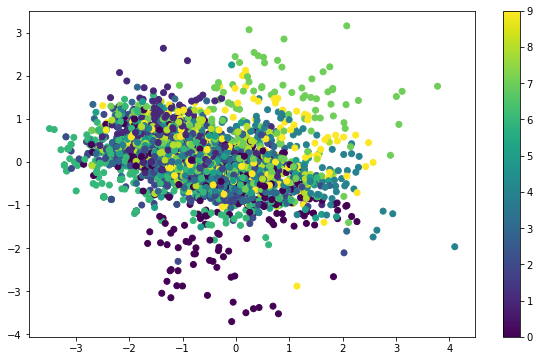

In [6]:
x_test, label_test = mnist.train.next_batch(M)
sess = ed.get_session()
encoded_mean_test = sess.run(qz.mean(), {x_ph: x_test})
plt.figure(figsize=(10, 6))
plt.scatter(encoded_mean_test[:,0],encoded_mean_test[:,1],c=label_test)
plt.colorbar()
plt.show()


In [7]:
lat_0 = np.where(label_test==0)
lat_1 = np.where(label_test==1)
lat_2 = np.where(label_test==2)
lat_3 = np.where(label_test==3)
lat_4 = np.where(label_test==4)
lat_5 = np.where(label_test==5)
lat_6 = np.where(label_test==6)
lat_7 = np.where(label_test==7)
lat_8 = np.where(label_test==8)
lat_9 = np.where(label_test==9)

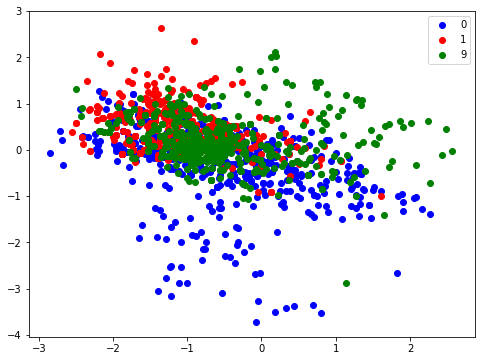

In [8]:
dig1=lat_0
dig2=lat_1
dig3=lat_9
plt.figure(figsize=(8, 6))
plt.scatter(encoded_mean_test[dig1,0],encoded_mean_test[dig1,1],c='blue',label=label_test[dig1][0])
plt.scatter(encoded_mean_test[dig2,0],encoded_mean_test[dig2,1],c='red',label=label_test[dig2][0])
plt.scatter(encoded_mean_test[dig3,0],encoded_mean_test[dig3,1],c='green',label=label_test[dig3][0])
plt.legend()
plt.show()


In [19]:
MM = 10000
z_test1 = np.linspace(2.0,-3.0,MM)
z_test2 = np.linspace(3.0,-3.0,MM)
zz = np.asarray([z_test1,z_test2])
zz =np.transpose(zz)

In [24]:
zz.shape

(10000, 2)

In [22]:
z

<ed.RandomVariable 'Normal/' shape=(10000, 2) dtype=float32>

In [1]:
sess = ed.get_session()
img2 = sess.run(x,{z: zz})

NameError: name 'ed' is not defined

In [15]:
def draw_digits2(digits, n_rows):
    n = n_rows**2
    n_cols = n_rows
    for i in range(0, n):
        plt.figsize=(12,12)
        plt.subplot(n_rows, n_cols, i+1)
        img = digits[int(n_rows*i)].reshape(28,28)
        plt.imshow(img, cmap='gray', interpolation='none')
        plt.axis('off')
        plt.subplots_adjust(hspace=0.0, wspace=0.0)

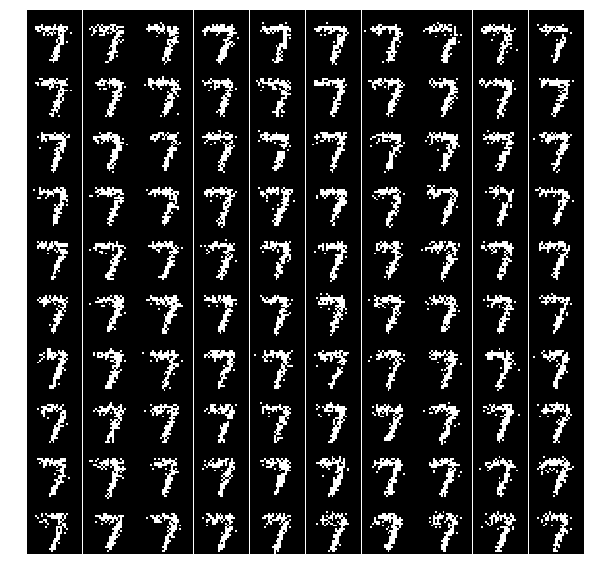

In [16]:
fig = plt.figure(figsize=(10,10))
draw_digits2(img2,10)

In [ ]:
def draw_digits(digits, n_rows):
    n = len(digits)
    n_cols = int(n / n_rows)
    for i in range(0, n):
        plt.figsize=(12,12)
        plt.subplot(n_rows, n_cols, i+1)
        img = digits[i].reshape(28,28)
        plt.imshow(img, cmap='gray', interpolation='none')
        plt.axis('off')
        plt.subplots_adjust(hspace=0.0, wspace=0.5)

In [ ]:
sz=10
fig = plt.figure(figsize=(12, 12))
draw_digits(img2,np.sqrt(sz))

In [17]:
def draw_digits(digits, n_rows):
    n = len(digits)
    n_cols = int(n / n_rows)
    for i in range(0, n):
        plt.figsize=(12,12)
        plt.subplot(n_rows, n_cols, i+1)
        img = digits[i].reshape(28,28)
        plt.imshow(img, cmap='gray', interpolation='none')
        plt.axis('off')
        plt.subplots_adjust(hspace=0.0, wspace=0.5)

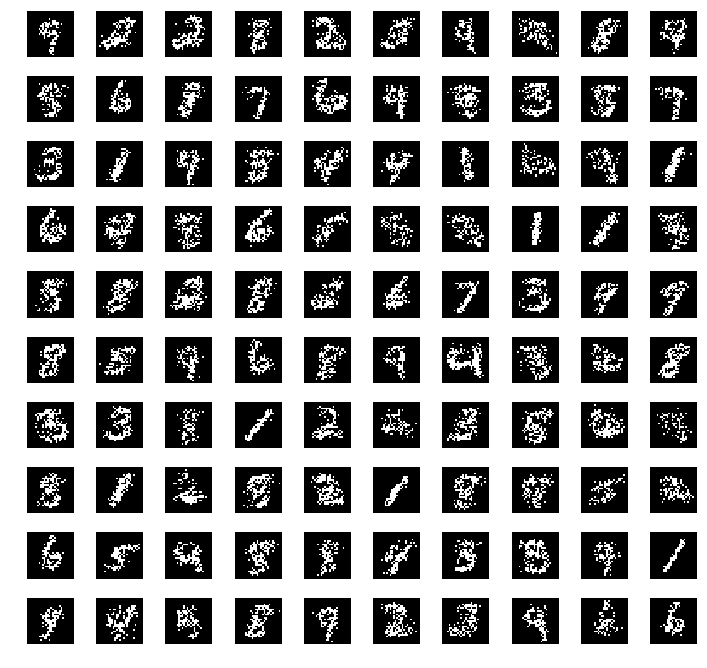

In [18]:
sz=100
fig = plt.figure(figsize=(12, 12))
draw_digits(imgs[0:sz],np.sqrt(sz))